<b>Problem Statement

Rice (Oryza sativa) is one of the staple foods worldwide. Paddy, the raw grain before removal of husk, is cultivated in tropical climates, mainly in Asian countries. Paddy cultivation requires consistent supervision because several diseases and pests might affect the paddy crops, leading to up to 70% yield loss. Expert supervision is usually necessary to mitigate these diseases and prevent crop loss. With the limited availability of crop protection experts, manual disease diagnosis is tedious and expensive. Thus, it is increasingly important to automate the disease identification process by leveraging computer vision-based techniques that achieved promising results in various domains.
Objective

The main objective of this competition is to develop a machine or deep learning-based model to classify the given paddy leaf images accurately. We provide a training dataset of 10,407 (75%) labeled images across ten classes (nine disease categories and normal leaf). Moreover, we also provide additional metadata for each image, such as the paddy variety and age. Your task is to classify each paddy image in the given test dataset of 3,469 (25%) images into one of the nine disease categories or a normal leaf. </b>

<b>We provide a training dataset of 10,407 (75%) labeled paddy leaf images across ten classes (nine diseases and normal leaf). We also provide additional metadata for each image, such as the paddy variety and age. Your task is to develop an accurate disease classification model using the training dataset and then classify each sample in the test dataset of 3,469 (25%) paddy leaf images into one of the nine diseases or normal leaf.
Files

train.csv - The training set

    image_id - Unique image identifier corresponds to image file names (.jpg) found in the train_images directory.
    label - Type of paddy disease, also the target class. There are ten categories, including the normal leaf.
    variety - The name of the paddy variety.
    age - Age of the paddy in days.

sample_submission.csv - Sample submission file.

train_images - This directory contains 10,407 training images stored under different sub-directories corresponding to ten target classes. Filename corresponds to the image_id column of train.csv.

test_images - This directory contains 3,469 test set images. </b>

In [106]:
#!pip install -U torch torchvision

In [107]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [108]:
torch. __version__
    

'1.11.0'

In [109]:
#import zipfile


In [110]:
# #with zipfile.ZipFile('C:/Users/Андрей/DEEP_LEARNING/paddy_desease/paddy-disease-classification.zip', 'r') as zip_ref:
#     zip_ref.extractall()


In [111]:
#!pip install Pillow
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import albumentations as albu
from albumentations.pytorch import ToTensorV2


In [112]:
import pickle
import numpy as np

from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms,  models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.models as models

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [113]:
random_seed = 42 
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

In [114]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")


In [115]:
class PaddyDeseaseDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        #files for upload
        self.files = sorted(files)
        self.mode = mode
        
        if self.mode not in DATA_MODES:
            print(f'{self.mode} is not correct mode, change modes: {DATA_MODES}')
            raise NameError
        
        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()
        
        if self.mode != "test":
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
            
            with open("Label_encoder.pkl", "wb") as le_dump_file:
                pickle.dump(self.label_encoder, le_dump_file)
        
        
    def __len__(self):
        return self.len_
    
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        tens = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        transform1 = albu.Compose([
            #albu.RandomCrop(width=256, height=256),
            albu.HorizontalFlip(p=0.5),
            albu.RandomBrightnessContrast(p=0.2),
                    albu.ShiftScaleRotate( 
            shift_limit=0.1,
            scale_limit=0.1,
            rotate_limit=15,
            border_mode=2,
            p=0.5
            ),
            #albu.IAAPerspective(scale=(0.02, 0.05), p=0.3),
            # Random brightness / contrast with a 30% probability
            #albu.RandomBrightnessContrast(
#                 brightness_limit=0.2, contrast_limit=0.2, p=0.3
#             ),
            # Random gamma changes with a 30% probability
            albu.RandomGamma(gamma_limit=(85, 115), p=0.3),
            # Randomly changes the hue, saturation, and color value of the input image
            #albu.HueSaturationValue(p=0.3),
            albu.JpegCompression(quality_lower=80)])
        
        x = self.load_sample(self.files[index])    
        x = self._prepare_sample(x)  
        x = np.array(x / 255, dtype='float32')
        if self.mode == ('test' or 'val'):
            x = tens(x)
            return x
        else:
            #x = transform1(image=x)['image']
            x = tens(x)   
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

        

In [116]:
TRAIN_DIR = Path('C:/Users/Андрей/DEEP_LEARNING/paddy_desease/train_images')
TEST_DIR = Path('C:/Users/Андрей/DEEP_LEARNING/paddy_desease/test_images')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [117]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2, \
                                          stratify=train_val_labels)


In [118]:
#number of folders(classes) in dataset
temp = set()
for i in train_val_labels:
  temp.add(i)
print(len(temp))  

10


In [119]:
val_dataset = PaddyDeseaseDataset(val_files, mode='val')

In [120]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

C:\Anaconda\lib\site-packages\albumentations\augmentations\transforms.py:965: FutureWarning: This class has been deprecated. Please use ImageCompression
  warnings.warn(


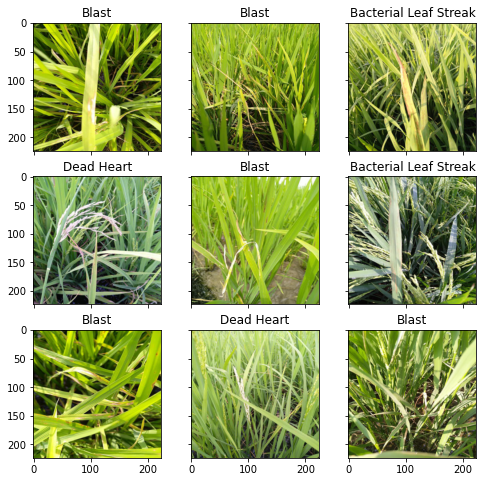

In [121]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [122]:
#Check counts of examples of each category in dataset. Need to ensure for proper balancing
classes, counts = np.unique(train_val_labels, return_counts=True)
dct_grass = dict(zip(classes, counts))
print(dct_grass)

{'bacterial_leaf_blight': 479, 'bacterial_leaf_streak': 380, 'bacterial_panicle_blight': 337, 'blast': 1738, 'brown_spot': 965, 'dead_heart': 1442, 'downy_mildew': 620, 'hispa': 1594, 'normal': 1764, 'tungro': 1088}


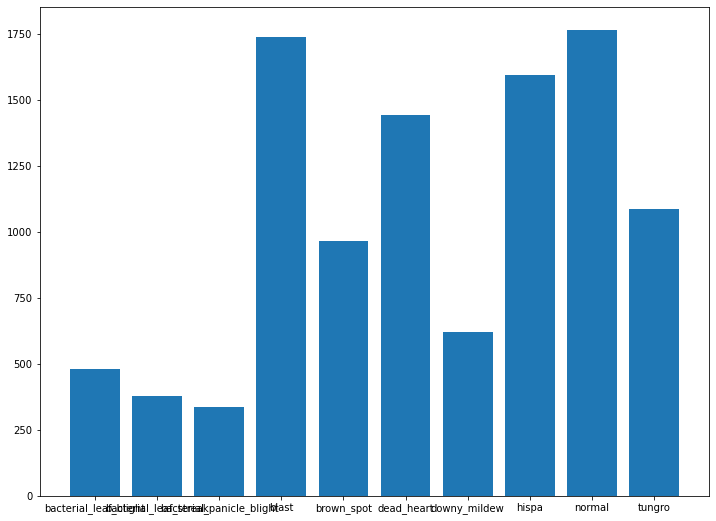

In [123]:
plt.figure(figsize=(12, 9))
plt.bar(dct_grass.keys(), dct_grass.values())
plt.show()

Classes are unbalanced. Let's balance them

In [124]:
#Dict with normalized number of examples of each labels
dct_desease_wht = {}
for key in dct_grass:
    dct_desease_wht.update({key : 1. / dct_grass[key]})

In [125]:
#Balancing weights for each category of labels
train_labels =  [path.parent.name for path in train_files]
val_lables =  [path.parent.name for path in val_files]

def count_weights_from_labels(train_val_labels, dct_desease_wht):
    weights = []
    for  i in train_val_labels:
        weights.append(dct_desease_wht[i])
    return weights

samples_train_weight = count_weights_from_labels(train_labels, dct_desease_wht)
samples_val_weight = count_weights_from_labels(val_lables, dct_desease_wht)

<h2> Modelling </h2>

In [126]:
#!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

In [127]:
model = models.efficientnet_b0(pretrained=True)

In [128]:
model

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(
 

In [129]:
for param in model.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [130]:
#замораживаем параметры (веса)
# for param in model.parameters():
#      param.requires_grad = False

# layers_to_unfreeze = 5
#  #замораживаем параметры (веса)
# for param in model.features[:-layers_to_unfreeze].parameters():
#     param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 1280
# Заменяем Fully-Connected слой на наш линейный классификатор
model.classifier = nn.Linear(num_features, 10)

# Использовать ли GPU
if torch.cuda.is_available():
    model = model.cuda()

In [131]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0
    running_corrects = 0
    processed_data = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
        
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [132]:
def eval_epoch(model, val_loader, criterion):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    model.eval()
    running_loss = 0
    running_corrects = 0
    processed_data = 0
    
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
        
    val_loss = running_loss / processed_data
    val_acc = running_corrects.cpu().numpy() / processed_data
    
    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = model.state_dict()
    return val_loss, val_acc   

In [133]:

def train(train_files, val_files, model, epochs, batch_size):
    sampler_train_wht = torch.utils.data.WeightedRandomSampler(samples_train_weight, len(samples_train_weight))  
    sampler_val_wht = torch.utils.data.WeightedRandomSampler(samples_val_weight, len(samples_val_weight))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        
        #opt = torch.optim.Adam(model.parameters(), lr=1e-4)     
        opt = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.05) 
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [134]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [135]:
if val_dataset is None:
    val_dataset = PaddyDeseaseDataset(val_files, mode='val')
    
train_dataset = PaddyDeseaseDataset(train_files, mode='train')

In [136]:
history = train(train_dataset, val_dataset, model=model, epochs=9, batch_size=32)

epoch:   0%|                                                                                     | 0/9 [00:00<?, ?it/s]

loss 1.2366760599147808


epoch:  11%|████████▍                                                                   | 1/9 [02:17<18:23, 137.95s/it]


Epoch 001 train_loss: 1.2367     val_loss 0.5239 train_acc 0.6202 val_acc 0.8391
loss 0.3505300213714262


epoch:  22%|████████████████▉                                                           | 2/9 [04:25<15:23, 132.00s/it]


Epoch 002 train_loss: 0.3505     val_loss 0.3376 train_acc 0.8836 val_acc 0.8862
loss 0.12003280666676369


epoch:  33%|█████████████████████████▎                                                  | 3/9 [06:48<13:41, 136.92s/it]


Epoch 003 train_loss: 0.1200     val_loss 0.2214 train_acc 0.9619 val_acc 0.9328
loss 0.052748224638603826


epoch:  44%|█████████████████████████████████▊                                          | 4/9 [09:30<12:14, 146.90s/it]


Epoch 004 train_loss: 0.0527     val_loss 0.1804 train_acc 0.9835 val_acc 0.9481
loss 0.03730198933857608


epoch:  56%|██████████████████████████████████████████▏                                 | 5/9 [11:36<09:17, 139.34s/it]


Epoch 005 train_loss: 0.0373     val_loss 0.2139 train_acc 0.9882 val_acc 0.9462
loss 0.04928804418010576


epoch:  67%|██████████████████████████████████████████████████▋                         | 6/9 [14:03<07:05, 141.72s/it]


Epoch 006 train_loss: 0.0493     val_loss 0.1976 train_acc 0.9864 val_acc 0.9462
loss 0.037208506404492143


epoch:  78%|███████████████████████████████████████████████████████████                 | 7/9 [16:04<04:30, 135.18s/it]


Epoch 007 train_loss: 0.0372     val_loss 0.2050 train_acc 0.9876 val_acc 0.9520
loss 0.03262916561252474


epoch:  89%|███████████████████████████████████████████████████████████████████▌        | 8/9 [18:21<02:15, 135.62s/it]


Epoch 008 train_loss: 0.0326     val_loss 0.1977 train_acc 0.9898 val_acc 0.9472
loss 0.014341066286762108


epoch: 100%|████████████████████████████████████████████████████████████████████████████| 9/9 [20:48<00:00, 138.67s/it]


Epoch 009 train_loss: 0.0143     val_loss 0.1833 train_acc 0.9954 val_acc 0.9587


In [137]:
loss, acc, val_loss, val_acc = zip(*history)

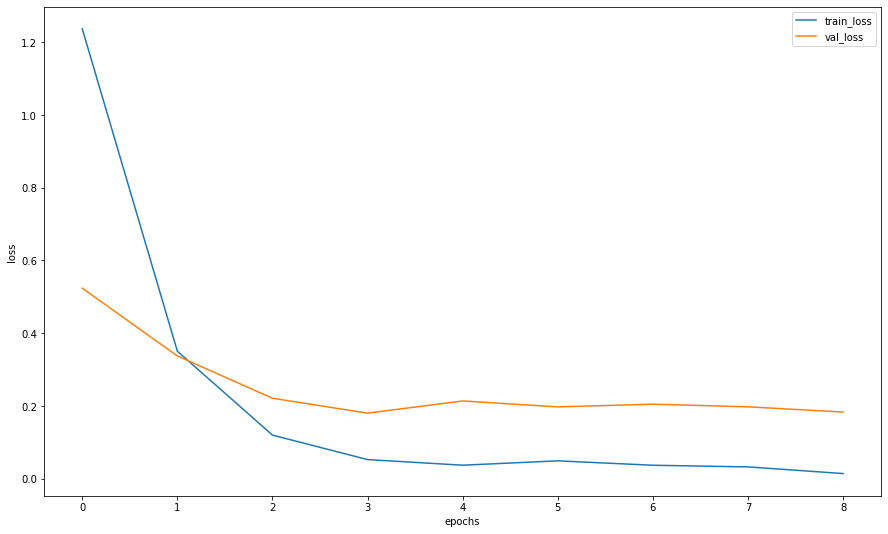

In [138]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [139]:
#model.load_state_dict(best_model_wts)

In [140]:
torch.save(model.state_dict(), 'C:/Users/Андрей/DEEP_LEARNING/paddy_desease/Eff_b0f')

In [141]:
#function for one-time predict of one picture
def predict_picture(model, inputs, device=DEVICE):
    with torch.no_grad():
        inputs = inputs.to(DEVICE)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [142]:
random_num = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_num]
probs_im = predict_picture(model, ex_img.unsqueeze(0))

In [143]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [144]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [145]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]
y_pred = y_pred.tolist()

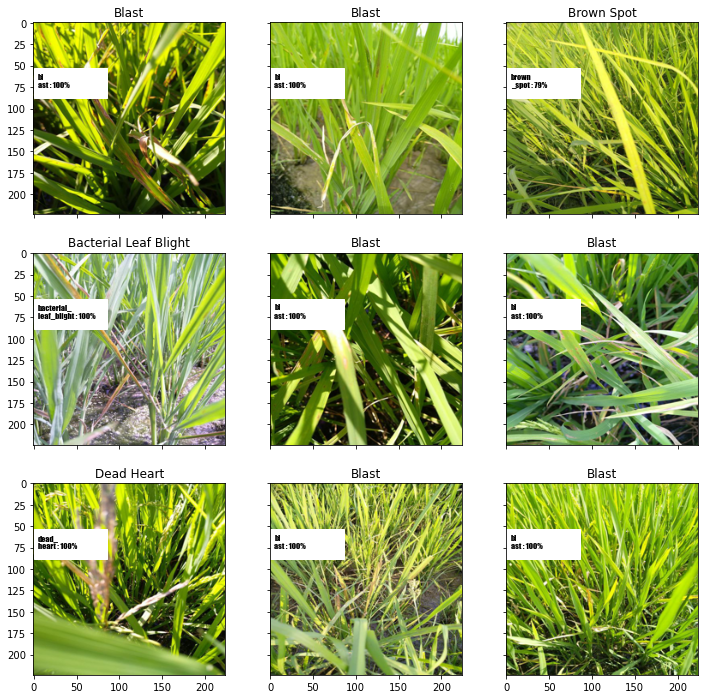

In [146]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_picture(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(5, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Kaggle submit

In [150]:
test_dataset = PaddyDeseaseDataset(test_files, mode='test')
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
probs = predict(model, test_loader)

predictions = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames =[path.name for path in test_dataset.files]

In [200]:
test_filenames = pd.DataFrame(test_filenames)
predictions = pd.DataFrame(predictions) 
submit = pd.concat((test_filenames,predictions), axis = 1)

In [204]:
submit.columns = ["image_id","label"]

In [205]:
submit.to_csv('C:/Users/Андрей/DEEP_LEARNING/paddy_desease/Kaggle_submit.csv', index=False)